In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')

In [4]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools
from ConceptBottleneck.CUB.template_model import FC, InceptionAux
import random
import numpy as np

In [5]:
from ConceptBottleneck.CUB.models import ModelXtoC, ModelOracleCtoY
from ConceptBottleneck.CUB.dataset import load_data

In [6]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [47]:
num_objects = 1
noisy=False
weight_decay = 0.004
encoder_model='small3'

In [54]:
def get_log_folder(dataset,weight_decay,encoder_model):
    if weight_decay == 0.0004 and encoder_model == 'inceptionv3':
        log_folder = f"results/{dataset}/joint/joint"
    elif weight_decay == 0.0004:
        log_folder = f"results/{dataset}/joint_model_{encoder_model}/joint"
    else:
        log_folder = f"results/{dataset}/joint_model_{encoder_model}_wd_{weight_decay}/joint"
    return log_folder

In [24]:
dataset_name = "synthetic_{}".format(num_objects)
if noisy:
    dataset_name += "_noisy"

data_dir = "../cem/cem/{}/preprocessed/".format(dataset_name)

In [25]:
if num_objects == 2:
    concept_combinations = [
        [1,0,1,0],
        [0,1,0,1],
        [1,0,0,1],
        [0,1,1,0],
    ]
    concept_y = [
        0,1,1,1
    ]
else:
    concept_combinations = []
    concept_y = []
    for i in range(128):
        is_triangle = [random.randint(0,1) for j in range(num_objects)]
        is_square = [1-j for j in is_triangle]
        
        attribute_label = [elem for pair in zip(is_triangle, is_square) for elem in pair]
        concept_combinations.append(attribute_label)
        
        task_y = int(sum(is_square)<num_objects//2)
        concept_y.append(task_y)

In [26]:
train_data_path = os.path.join(data_dir, 'train.pkl')
val_data_path = train_data_path.replace('train.pkl', 'val.pkl')
extra_data_path = train_data_path.replace('train.pkl','extra.pkl')

In [27]:
pretrained = True
freeze = False
use_aux = True
expand_dim = 0
three_class = False
use_attr = True
no_img = False
batch_size = 64
uncertain_labels = False
image_dir = 'images'
num_class_attr = 2
resampling = False

In [28]:
train_loader = load_data([train_data_path], use_attr, no_img, batch_size, uncertain_labels, image_dir=image_dir, 
                         n_class_attr=num_class_attr, resampling=resampling, path_transform=lambda path: "../cem/cem/"+path, is_training=False)
val_loader = load_data([val_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)

In [55]:
log_folder = get_log_folder(dataset_name,weight_decay,encoder_model)
joint_location = "ConceptBottleneck/{}/best_model_42.pth".format(log_folder)
joint_model = torch.load(joint_location,map_location=torch.device('cpu'))
r = joint_model.eval()

## Plot the Dataset

In [30]:
train_pkl = pickle.load(open(train_data_path,"rb"))
val_pkl = pickle.load(open(val_data_path,"rb"))

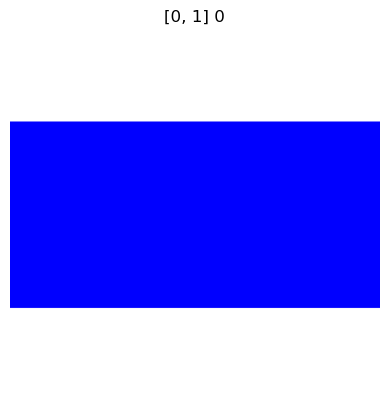

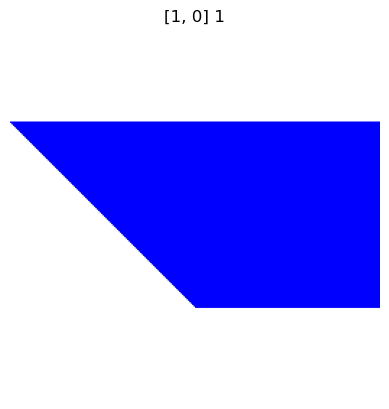

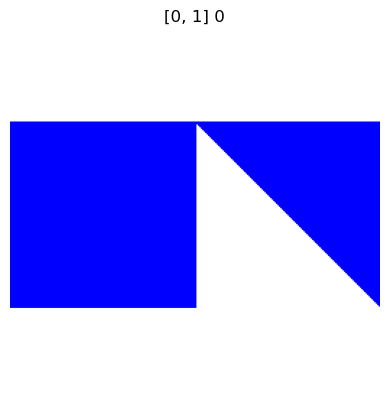

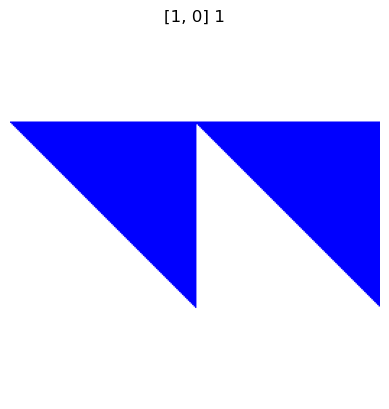

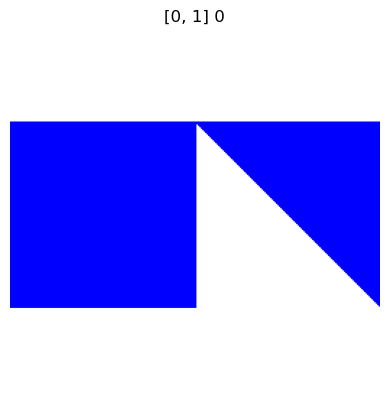

In [31]:
num_images_show = 5
for i in range(num_images_show):
    img_path = '../cem/cem/'+train_pkl[i]['img_path']
    image = Image.open(img_path)
    image_array = np.array(image)
    plt.figure()
    plt.imshow(image_array)
    plt.axis('off') 
    plt.title(str(train_pkl[i]['attribute_label']) + ' '+str(train_pkl[i]['class_label']))

## Analyze Concept-Task Relationships

In [56]:
val_images = []
val_y = []
val_c = []
for batch in val_loader:
    x, y, c = batch  
    val_images.append(x)
    val_y.append(y)
    val_c.append(torch.stack(c).T)
val_images = torch.cat(val_images, dim=0)
val_y = torch.cat(val_y,dim=0)
val_c = torch.cat(val_c,dim=0)

## Analyze Concept-Input Relationships

### Maximal Activation

In [57]:
ret_image_left = get_maximal_activation(joint_model,run_joint_model,0,valid_left_image,lamb=1)

In [58]:
torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image_left)[1])

tensor([[0.9848],
        [0.0118]], grad_fn=<SigmoidBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


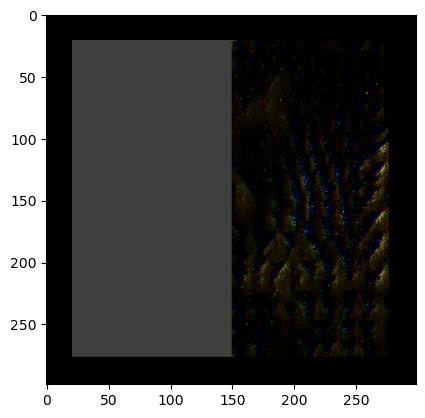

In [59]:
plt.imshow(ret_image_left.detach()[0].numpy().transpose((1,2,0)))

In [21]:
ret_image = get_maximal_activation(joint_model,run_joint_model,3,valid_right_image,lamb=1)

KeyboardInterrupt: 

In [ ]:
torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image)[1])

tensor([[1.0000e+00],
        [1.1874e-05],
        [4.6915e-30],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


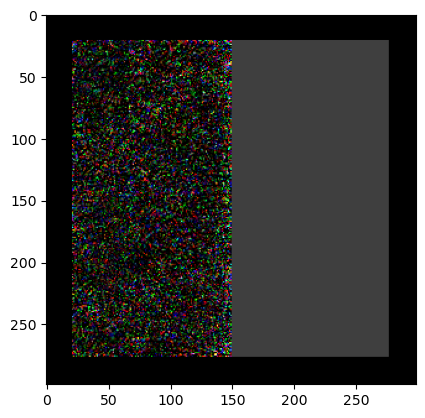

In [ ]:
plt.imshow(ret_image.detach()[0].numpy().transpose((1,2,0)))

## Using only one Filter

In [ ]:
no_color = torch.Tensor([0.25,0.25,0.25])
border_color = torch.Tensor([-0.25,-0.25,-0.25])
blank_image = no_color.clone().view(3, 1, 1).expand((3,256,256))
blank_image = image_with_borders(blank_image,border_color,21,22,21,22)
activations_blank = get_last_filter_activations(joint_model,run_joint_model,torch.stack([blank_image]),0)
indices_blank = np.argsort(activations_blank)

In [ ]:
idx_1010 = [i for i,num in enumerate(val_c) if num[0] == num[2] == 1][0]
idx_1001 = [i for i,num in enumerate(val_c) if num[0] == num[3] == 1][0]

IndexError: index 2 is out of bounds for dimension 0 with size 2

In [ ]:
activations_1010 = get_last_filter_activations(joint_model,run_joint_model,val_images[idx_1010:idx_1010+1],0)
# activations_1010 -= activations_blank
indices_1010 = np.argsort(activations_1010)

In [ ]:
activations_1001 = get_last_filter_activations(joint_model,run_joint_model,val_images[idx_1001:idx_1001+1],0)
# activations_1001 -= activations_blank
indices_1001 = np.argsort(activations_1001)

In [ ]:
activations_adversarial = get_last_filter_activations(joint_model,run_joint_model,ret_image_left,0)
# activations_adversarial -= activations_blank
indices_adversarial = np.argsort(activations_adversarial)

In [ ]:
activations_0101 = get_last_filter_activations(joint_model,run_joint_model,val_images[0:1],0)
# activations_0101 -= activations_blank
indices_0101 = np.argsort(activations_0101)

### Analyze Common Filters

In [ ]:
common_filters = (set(indices_1010[-10:]).intersection(
    set(indices_1001[-10:])).intersection(indices_adversarial[-10:]))
common_filters = list(common_filters)

In [ ]:
get_last_filter_activations(joint_model,run_joint_model,ret_image_left,0)

array([ 1.4944367e-01, -7.4152529e-02,  1.1236342e-03, ...,
       -7.6388337e-02,  8.9430760e-05,  3.8159799e-02], dtype=float32)

In [ ]:
filter_activations = joint_model.first_model.last_conv_output[0]
filter_activations = filter_activations.detach().numpy()
filter_activations -= np.min(filter_activations)
filter_activations /= np.max(filter_activations)

In [ ]:
def show_filter(num):
    resized_filter = cv2.resize(filter_activations[num],(val_images[0].shape[1],val_images[0].shape[2]))
    plt.figure()
    plt.imshow(resized_filter,cmap='gray')

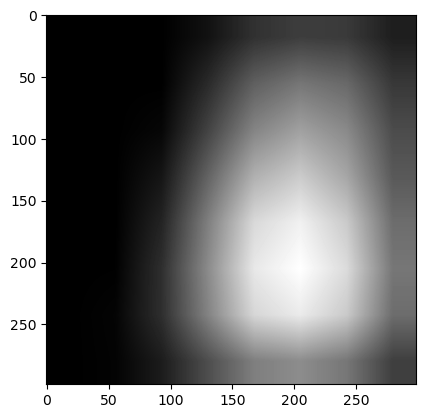

In [ ]:
for i in set(indices_1001[-10:]).intersection(indices_1010[-10:]):
    show_filter(i)

In [ ]:
for i in common_filters:
    print(i)
    show_filter(i)

In [ ]:
[activations_blank[i] for i in common_filters]

[]

In [ ]:
for i in common_filters:
    print(activations_1010[i], activations_1001[i], activations_adversarial[i],activations_0101[i])